In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.7
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 619ms/step - loss: 0.0251
Average validation loss: 0.6521676778793335
4/4 [==============================] - 7s 631ms/step - loss: 0.0251 - val_loss: 0.6522
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 9s 631ms/step - loss: 0.0179 - val_loss: 0.6522
Average validation loss: 0.5590335726737976
4/4 [==============================] - 9s 646ms/step - loss: 0.0179 - val_loss: 0.6056
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 12s 760ms/step - loss: 0.0135 - val_loss: 0.6056
Average validation loss: 0.4364258050918579
4/4 [==============================] - 12s 774ms/step - loss: 0.0135 - val_loss

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 733ms/step - loss: 1.8555e-05
Average validation loss: 0.01264697639271617
8/8 [==============================] - 6s 743ms/step - loss: 1.8555e-05 - val_loss: 0.0126
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 709ms/step - loss: 1.8203e-05 - val_loss: 0.0126
Average validation loss: 0.013557922560721636
8/8 [==============================] - 12s 721ms/step - loss: 1.8203e-05 - val_loss: 0.0131
Epoch 3/10
8/8 [==============================] - 17s 716ms/step - loss: 1.8055e-05 - val_loss: 0.0131
Average validation loss: 0.010674743913114071
8/8 [==============================] - 17s 727ms/step - loss: 1.8055e-05 - val_loss: 0.0123
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segfo

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 740ms/step - loss: 4.4908e-05
Average validation loss: 0.07108159386780244
12/12 [==============================] - 9s 751ms/step - loss: 4.4908e-05 - val_loss: 0.0711
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 742ms/step - loss: 4.2425e-05 - val_loss: 0.0711
Average validation loss: 0.030824045844686527
12/12 [==============================] - 18s 753ms/step - loss: 4.2425e-05 - val_loss: 0.0510
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 27s 727ms/step - loss: 4.1317e-05 - val_loss: 0.0510
Average validation loss: 0.1740254497410998
12/12 [==============================] - 2

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 706ms/step - loss: 2.7873e-05
Average validation loss: 0.06553648816128543
16/16 [==============================] - 11s 718ms/step - loss: 2.7873e-05 - val_loss: 0.0655
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 704ms/step - loss: 2.7399e-05 - val_loss: 0.0655
Average validation loss: 0.02229322463972494
16/16 [==============================] - 23s 715ms/step - loss: 2.7399e-05 - val_loss: 0.0439
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 34s 693ms/step - loss: 2.8432e-05 - val_loss: 0.0439
Average validation loss: 0.031856531742960215
16/16 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 686ms/step - loss: 1.5944e-05
Average validation loss: 0.08159937288414768
20/20 [==============================] - 14s 697ms/step - loss: 1.5944e-05 - val_loss: 0.0816
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 28s 696ms/step - loss: 1.5192e-05 - val_loss: 0.0816
Average validation loss: 0.053048347483854744
20/20 [==============================] - 28s 706ms/step - loss: 1.5192e-05 - val_loss: 0.0673
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 42s 697ms/step - loss: 1.4424e-05 - val_loss: 0.0673
Average validation loss: 0.025775250559672714
20/20 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 697ms/step - loss: 2.5426e-05
Average validation loss: 0.049136520052949585
24/24 [==============================] - 17s 706ms/step - loss: 2.5426e-05 - val_loss: 0.0491
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 694ms/step - loss: 2.1276e-05 - val_loss: 0.0491
Average validation loss: 0.020491947419941425
24/24 [==============================] - 34s 704ms/step - loss: 2.1276e-05 - val_loss: 0.0348
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 51s 699ms/step - loss: 1.9326e-05 - val_loss: 0.0348
Average validation loss: 0.034066365410884224
24/24 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 31s 764ms/step - loss: 3.5993e-05
Average validation loss: 0.03483182713389397
40/40 [==============================] - 31s 774ms/step - loss: 3.5993e-05 - val_loss: 0.0348
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 62s 767ms/step - loss: 3.2125e-05 - val_loss: 0.0348
Average validation loss: 0.06004819646477699
40/40 [==============================] - 62s 777ms/step - loss: 3.2125e-05 - val_loss: 0.0474
Epoch 3/10
40/40 [==============================] - 92s 754ms/step - loss: 2.9247e-05 - val_loss: 0.0474
Average validation loss: 0.040533962100744246
40/40 [==============================] - 93s 764ms/step - loss: 2.9247e-05 - val_loss: 0.0451
Epoch 4/10
40/40 [==============================] - 123s 757ms/step - loss: 2.7192e-05 - val_loss: 0.0451
Average validat

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 37s 760ms/step - loss: 1.9905e-05
Average validation loss: 0.026116691743178915
48/48 [==============================] - 37s 770ms/step - loss: 1.9905e-05 - val_loss: 0.0261
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 74s 763ms/step - loss: 1.5884e-05 - val_loss: 0.0261
Average validation loss: 0.022775994264520705
48/48 [==============================] - 74s 773ms/step - loss: 1.5884e-05 - val_loss: 0.0244
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 111s 763ms/step - loss: 1.3060e-05 - val_loss: 0.0244
Average validation loss: 0.028969295672141016
48/48 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 698ms/step - loss: 2.9241e-05
Average validation loss: 0.021896863913363113
56/56 [==============================] - 40s 708ms/step - loss: 2.9241e-05 - val_loss: 0.0219
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 712ms/step - loss: 2.0620e-05 - val_loss: 0.0219
Average validation loss: 0.018620088964131094
56/56 [==============================] - 80s 722ms/step - loss: 2.0620e-05 - val_loss: 0.0203
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 120s 706ms/step - loss: 1.5729e-05 - val_loss: 0.0203
Average validation loss: 0.021370023291508135
56/56 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 49s 765ms/step - loss: 1.3870e-05
Average validation loss: 0.03441066242521629
64/64 [==============================] - 50s 775ms/step - loss: 1.3870e-05 - val_loss: 0.0344
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 99s 762ms/step - loss: 9.6091e-06 - val_loss: 0.0344
Average validation loss: 0.012825047393562272
64/64 [==============================] - 99s 773ms/step - loss: 9.6091e-06 - val_loss: 0.0236
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 148s 764ms/step - loss: 7.5368e-06 - val_loss: 0.0236
Average validation loss: 0.021575749429757707
64/64 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 55s 767ms/step - loss: 1.4131e-05
Average validation loss: 0.03159348382097152
72/72 [==============================] - 56s 778ms/step - loss: 1.4131e-05 - val_loss: 0.0316
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 111s 765ms/step - loss: 9.2563e-06 - val_loss: 0.0316
Average validation loss: 0.011869198772021465
72/72 [==============================] - 112s 776ms/step - loss: 9.2563e-06 - val_loss: 0.0217
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 167s 767ms/step - loss: 7.0829e-06 - val_loss: 0.0217
Average validation loss: 0.011472804834031396
72/72 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 61s 767ms/step - loss: 1.1340e-05
Average validation loss: 0.012865074095316231
80/80 [==============================] - 62s 778ms/step - loss: 1.1340e-05 - val_loss: 0.0129
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 124s 770ms/step - loss: 8.3376e-06 - val_loss: 0.0129
Average validation loss: 0.018630730360746382
80/80 [==============================] - 125s 781ms/step - loss: 8.3376e-06 - val_loss: 0.0157
Epoch 3/10
80/80 [==============================] - 186s 769ms/step - loss: 6.7441e-06 - val_loss: 0.0157
Average validation loss: 0.009854267700575292
80/80 [==============================] - 187s 780ms/step - loss: 6.7441e-06 - val_loss: 0.0138
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 67s 700ms/step - loss: 3.1273e-05
Average validation loss: 0.028667852486250922
96/96 [==============================] - 68s 710ms/step - loss: 3.1273e-05 - val_loss: 0.0287
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 136s 705ms/step - loss: 2.0863e-05 - val_loss: 0.0287
Average validation loss: 0.03677951210799316
96/96 [==============================] - 137s 715ms/step - loss: 2.0863e-05 - val_loss: 0.0327
Epoch 3/10
96/96 [==============================] - 205s 705ms/step - loss: 1.5551e-05 - val_loss: 0.0327
Average validation loss: 0.027360815545155976
96/96 [==============================] - 206s 715ms/step - loss: 1.5551e-05 - val_loss: 0.0309
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_06

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 84s 699ms/step - loss: 1.3475e-05
Average validation loss: 0.022376723300355176
120/120 [==============================] - 85s 709ms/step - loss: 1.3475e-05 - val_loss: 0.0224
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 169s 697ms/step - loss: 9.1162e-06 - val_loss: 0.0224
Average validation loss: 0.01430212629881377
120/120 [==============================] - 170s 707ms/step - loss: 9.1162e-06 - val_loss: 0.0183
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 255s 710ms/step - loss: 7.1970e-06 - val_loss: 0.0183
Average validation loss: 0.010242094883566703
120/120 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 101s 701ms/step - loss: 1.0390e-05
Average validation loss: 0.015246933558955789
144/144 [==============================] - 102s 711ms/step - loss: 1.0390e-05 - val_loss: 0.0152
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 204s 704ms/step - loss: 7.3572e-06 - val_loss: 0.0152
Average validation loss: 0.01608632541158133
144/144 [==============================] - 205s 714ms/step - loss: 7.3572e-06 - val_loss: 0.0157
Epoch 3/10
144/144 [==============================] - 306s 702ms/step - loss: 6.6709e-06 - val_loss: 0.0157
Average validation loss: 0.016546703797454636
144/144 [==============================] - 308s 711ms/step - loss: 6.6709e-06 - val_loss: 0.0160
Epoch 4/10
144/144 [==============================] - 409s 706ms/step - loss: 5.5668e-06 - val_loss: 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 113s 703ms/step - loss: 6.4858e-06
Average validation loss: 0.037967497936915603
160/160 [==============================] - 114s 713ms/step - loss: 6.4858e-06 - val_loss: 0.0380
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 227s 706ms/step - loss: 4.4531e-06 - val_loss: 0.0380
Average validation loss: 0.013202300213743001
160/160 [==============================] - 229s 716ms/step - loss: 4.4531e-06 - val_loss: 0.0256
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 342s 706ms/step - loss: 3.5018e-06 - val_loss: 0.0256
Average validation loss: 0.017381139297503977
160/160 [===========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 140s 702ms/step - loss: 1.9355e-05
Average validation loss: 0.049621187634766105
200/200 [==============================] - 142s 712ms/step - loss: 1.9355e-05 - val_loss: 0.0496
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 283s 702ms/step - loss: 1.3550e-05 - val_loss: 0.0496
Average validation loss: 0.01804430305957794
200/200 [==============================] - 285s 711ms/step - loss: 1.3550e-05 - val_loss: 0.0338
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 426s 707ms/step - loss: 1.0547e-05 - val_loss: 0.0338
Average validation loss: 0.01571651240810752
200/200 [=============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:44 - loss: 8.3843e-07

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 169s 704ms/step - loss: 1.0059e-05
Average validation loss: 0.017219356005080046
240/240 [==============================] - 171s 714ms/step - loss: 1.0059e-05 - val_loss: 0.0172
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 340s 702ms/step - loss: 6.5710e-06 - val_loss: 0.0172
Average validation loss: 0.015727406525547848
240/240 [==============================] - 342s 712ms/step - loss: 6.5710e-06 - val_loss: 0.0165
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 513s 712ms/step - loss: 5.1193e-06 - val_loss: 0.0165
Average validation loss: 0.017415395771968177
240/240 [===========

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.08094955443348936, 0.06953824831354012, 0.12767788065950017, 0.06639728174506115, 0.07544687315359368, 0.026203201003130134, 0.026120377737089258, 0.024316425790688455, 0.022422249498881035, 0.016614892614901466, 0.04250499565498888, 0.021826426437285384, 0.021570770417194657, 0.015470873989692335, 0.017772973867208747, 0.017191473405866416, 0.019564348248844635, 0.014785540853283239]
std_val_losses =  [0.14375669191932758, 0.09046046563855341, 0.13528943267148946, 0.049169611703603636, 0.09395552012972368, 0.018806119075583543, 0.014408341087780897, 0.013464923000791145, 0.011288609040242686, 0.00765911383771927, 0.06757166872701104, 0.017975581364818964, 0.011816430799947965, 0.007035816516898401, 0.006719295509642555, 0.008845157180160924, 0.014195105820996362, 0.006743549099757967]


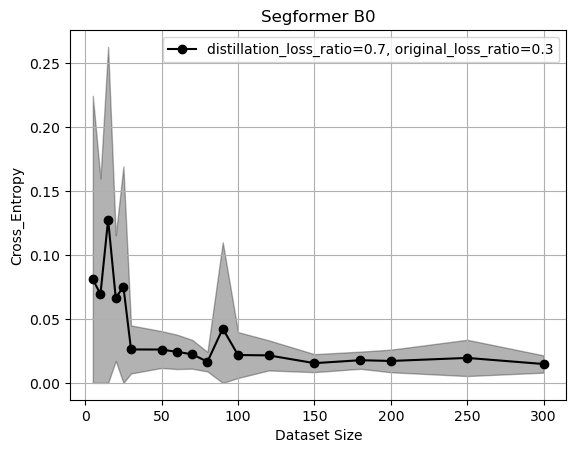

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()